C:\Users\chait\AppData\Local\Temp\ipykernel_15768\3080477900.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch  # Adjusted import statement


Reloading Tuner from hyperparam_tuning\pizza_demand_forecast\tuner0.json



c:\Users\chait\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\chait\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
114/114 - 12s - 101ms/step - loss: 0.0196
Epoch 2/50
114/114 - 9s - 83ms/step - loss: 0.0192
Epoch 3/50
114/114 - 9s - 83ms/step - loss: 0.0586
Epoch 4/50
114/114 - 10s - 85ms/step - loss: 0.0605
Epoch 5/50
114/114 - 10s - 83ms/step - loss: 0.0313
Epoch 6/50
114/114 - 9s - 82ms/step - loss: 0.0438
Epoch 7/50
114/114 - 9s - 81ms/step - loss: 0.0274
Epoch 8/50
114/114 - 9s - 82ms/step - loss: 0.0322
Epoch 9/50
114/114 - 9s - 81ms/step - loss: 0.0198
Epoch 10/50
114/114 - 9s - 82ms/step - loss: 0.0196
Epoch 11/50
114/114 - 10s - 83ms/step - loss: 0.0196
Epoch 12/50
114/114 - 10s - 83ms/step - loss: 0.0193
Epoch 13/50
114/114 - 9s - 82ms/step - loss: 0.0193
Epoch 14/50
114/114 - 9s - 82ms/step - loss: 0.0196
Epoch 15/50
114/114 - 9s - 82ms/step - loss: 0.0196
Epoch 16/50
114/114 - 9s - 75ms/step - loss: 0.0324
Epoch 17/50
114/114 - 9s - 82ms/step - loss: 0.0250
Epoch 18/50
114/114 - 9s - 82ms/step - loss: 0.0194
Epoch 19/50
114/114 - 9s - 82ms/step - loss: 0.0192
Epoch 20/50
114

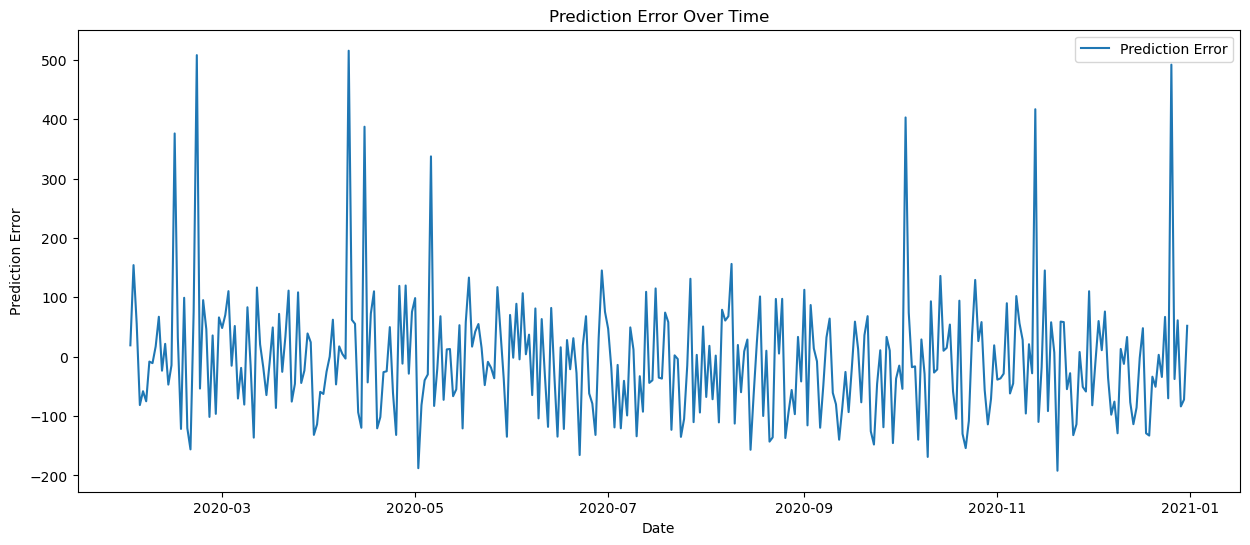

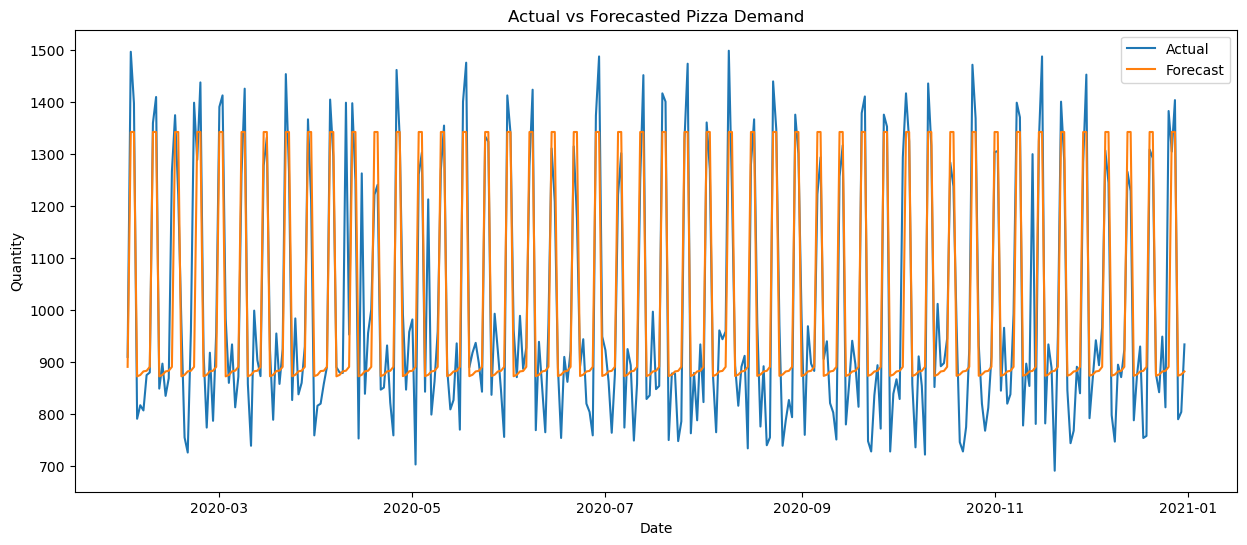

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from kerastuner.tuners import RandomSearch  # Adjusted import statement

# Load the dataset from both sheets
file_path = 'sam9.xlsx'  
df_sheet1 = pd.read_excel(file_path, sheet_name='Sheet_1')
df_sheet2 = pd.read_excel(file_path, sheet_name='Sheet_2')

# Concatenate the dataframes
df = pd.concat([df_sheet1, df_sheet2], ignore_index=True)

# Preprocess the data
df['datetime'] = pd.to_datetime(df['order_date'].astype(str) + ' ' + df['order_time'].astype(str))
df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')

# Aggregate the data by date to get the total quantity ordered each day
daily_data = df.groupby(pd.Grouper(key='datetime', freq='D')).agg({'quantity': 'sum'}).reset_index()

# Add seasonality features
daily_data['day_of_week'] = daily_data['datetime'].dt.dayofweek
daily_data['day_of_month'] = daily_data['datetime'].dt.day
daily_data['day_of_quarter'] = (daily_data['datetime'].dt.dayofyear - 1) // 90 + 1
daily_data['day_of_year'] = daily_data['datetime'].dt.dayofyear

# Filter train and test data
train_df = daily_data[(daily_data['datetime'] >= '2010-01-01') & (daily_data['datetime'] <= '2019-12-31')]
test_df = daily_data[(daily_data['datetime'] >= '2020-01-01') & (daily_data['datetime'] <= '2020-12-31')]

# Prepare the data for the LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[['quantity', 'day_of_week', 'day_of_month', 'day_of_quarter', 'day_of_year']])
test_scaled = scaler.transform(test_df[['quantity', 'day_of_week', 'day_of_month', 'day_of_quarter', 'day_of_year']])

# Define function to create dataset
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        X.append(a)
        Y.append(dataset[i + look_back, 0])  # Quantity is the target variable
    X_array, Y_array = np.array(X), np.array(Y)
    return X_array, Y_array

look_back = 30  # Look back period
trainX, trainY = create_dataset(train_scaled, look_back)
testX, testY = create_dataset(test_scaled, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

# Define the model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', min_value=50, max_value=200, step=50), return_sequences=True, input_shape=(look_back, trainX.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units2', min_value=50, max_value=200, step=50), return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units3', min_value=50, max_value=200, step=50)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')))
    return model

# Hyperparameter tuning
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='pizza_demand_forecast'
)

tuner.search(trainX, trainY, epochs=50, validation_split=0.2, batch_size=32)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Fit the best model
best_model.fit(trainX, trainY, epochs=50, batch_size=32, verbose=2)

# Make predictions
trainPredict = best_model.predict(trainX)
testPredict = best_model.predict(testX)

# Inverse transform predictions and actual values
trainPredict = scaler.inverse_transform(np.concatenate((trainPredict, np.zeros((trainPredict.shape[0], 4))), axis=1))[:,0]
trainY = scaler.inverse_transform(np.concatenate((trainY.reshape(-1, 1), np.zeros((trainY.shape[0], 4))), axis=1))[:,0]
testPredict = scaler.inverse_transform(np.concatenate((testPredict, np.zeros((testPredict.shape[0], 4))), axis=1))[:,0]
testY = scaler.inverse_transform(np.concatenate((testY.reshape(-1, 1), np.zeros((testY.shape[0], 4))), axis=1))[:,0]

# Calculate accuracy metrics
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
mae = mean_absolute_error(testY, testPredict)
mse = mean_squared_error(testY, testPredict)
rmse = np.sqrt(mse)  # Calculating RMSE from MSE
mape = np.mean(np.abs((testY - testPredict) / testY)) * 100
accuracy = 100 - mape

# Print accuracy metrics
print(f'Train RMSE: {trainScore}')
print(f'Test RMSE: {testScore}')
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")  # Printing RMSE
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"Accuracy: {accuracy}%")

# Extend test data to include up to January 2021
test_df_extended = daily_data[(daily_data['datetime'] >= '2020-01-01') & (daily_data['datetime'] <= '2021-01-31')]
extended_test_scaled = scaler.transform(test_df_extended[['quantity', 'day_of_week', 'day_of_month', 'day_of_quarter', 'day_of_year']])
extended_testX, extended_testY = create_dataset(extended_test_scaled, look_back)
extended_testX = np.reshape(extended_testX, (extended_testX.shape[0], extended_testX.shape[1], extended_testX.shape[2]))
extended_testPredict = best_model.predict(extended_testX)
extended_testPredict = scaler.inverse_transform(np.concatenate((extended_testPredict, np.zeros((extended_testPredict.shape[0], 4))), axis=1))[:,0]
extended_testY = scaler.inverse_transform(np.concatenate((extended_testY.reshape(-1, 1), np.zeros((extended_testY.shape[0], 4))), axis=1))[:,0]

# Error Analysis for the extended range
error = extended_testY - extended_testPredict
plt.figure(figsize=(15, 6))
plt.plot(test_df_extended['datetime'][look_back+1:], error, label='Prediction Error')
plt.xlabel('Date')
plt.ylabel('Prediction Error')
plt.title('Prediction Error Over Time')
plt.legend()
plt.show()

# Plot the results for the extended range
plt.figure(figsize=(15, 6))
plt.plot(test_df_extended['datetime'][look_back+1:], extended_testY, label='Actual')
plt.plot(test_df_extended['datetime'][look_back+1:], extended_testPredict, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Actual vs Forecasted Pizza Demand')
plt.legend()
plt.show()

# Create a DataFrame containing actual and predicted values along with dates for the extended range
extended_results_df = pd.DataFrame({
    'Date': test_df_extended['datetime'][look_back+1:],
    'Actual_Quantity': extended_testY,
    'Predicted_Quantity': extended_testPredict
})

# Save the DataFrame to an Excel file
extended_results_df.to_excel('LSTM_season_qty_1_sam9_final.xlsx', index=False)